## Quantization, Making Models Smaller and Inference Faster

Quantization is a technique used in the optimization of large language models (LLMs). It reduces the precision of the model's parameters, effectively shrinking its size and computational requirements, while aiming to maintain its performance. The main approaches to quantization are:

- **Post-Training Static Quantization (PTQ Static)**: Converts at least model weights to a lower precision (e.g., from 32-bit floating-point to 8-bit integer) before inference. Converting also activations requires a calibration set to determine the optimal quantization parameters: scale and zero-point.

- **Post-Training Dynamic Quantization (PTQ Dynamic)**:  Quantizes typically the weights of linear layers in advance but activations are dynamically quantized during inference. Unlike static quantization, this method doesn't require a separate calibration step, making it more flexible in deployment. Although it's slightly slower than static quantization (the activations are read and written to memory in floating point format), it often preserves more of the model's original accuracy.

- **Quantization-Aware Training (QAT)**: Applies additional training to simulate the effects of quantization by rounding float32 values. This allows the model to learn (update the model parameters) to minimize the final loss when applying quantization. As a result, it generally achieves the best balance of model size reduction and accuracy preservation. However, it comes with the drawback of requiring a complete retraining of the model (end-to-end forward/backward propagation).

The intuition behind Quantization is that we can discretize floating-point values by mapping their range [`f_max`, `f_min`] into a smaller range of fixed-point numbers [`q_max`, `q_min`], and linearly distributing all values between these ranges. In practice, this typically reduces the precision of a 32-bit floating-point to lower bit widths like 8-bits (scalar quantization) or 1-bit values (binary quantization):

<p align="center">
  <img src="./static/model_quantization.png">
</p>

In this notebook, we introduce how quantization works specifically for LLMs, demonstrating its practical implementation (PTQ Dynamic) and benchmarking in terms of model size, inference latency, and accuracy.

In [ ]:
%pip install transformers datasets evaluate --quiet | tail -n 1

### 1. Load BERT Transformer Model

We use a BERT-base model that has been fine-tuned for intent classification using the [clinc dataset](https://huggingface.co/datasets/clinc/clinc_oos):

In [41]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

/usr/local/python/3.10.13/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [42]:
query = """I need to book a flight from New York to Tokyo for next month in economy class"""
pipe(query)

[{'label': 'book_flight', 'score': 0.5934060215950012}]

#### 1.1 Model Architecture

This BERT-based model is an encoder-only transformer composed of a stack of 12 layers. Note that each layer implements a self-attention mechanism (query, key, value linear transformations):

In [44]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt).to("cpu")
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#### 1.2 Weight Distribution in Query Attention Layer

By plotting the frequency distribution of the weights in an exemplary attention layer, we observe that the values are indeed concentrated around a relatively narrow range [-0.522441, +0.454290]. This means we can effectively map float32 values to 256 int8 buckets without significant loss of information:

model.bert.encoder.layer[0].attention.self.query.weight:
Min: -0.522441, Max: 0.454290


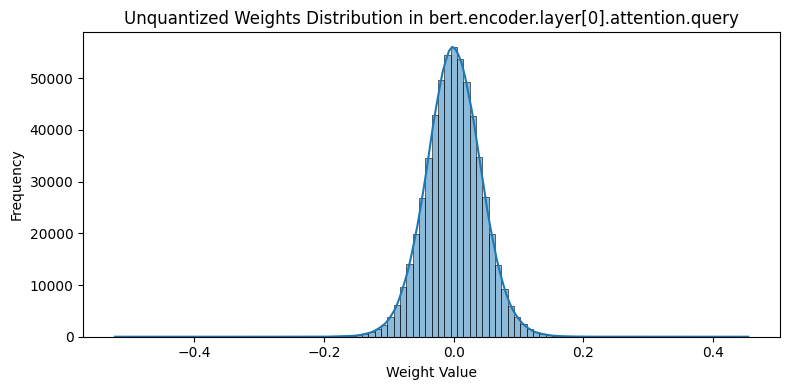

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def weights_distribution(model, layer_name):
    weights = model.bert.encoder.layer[0].attention.self.query.weight
    weights = weights.flatten().detach().cpu().numpy()

    print("model.bert.encoder.layer[0].attention.self.query.weight:")
    print(f"Min: {weights.min():.6f}, Max: {weights.max():.6f}")
    
    plt.figure(figsize=(8, 4))
    sns.histplot(weights, kde=True, bins=100)
    plt.title(f'Unquantized Weights Distribution in {layer_name}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

weights_distribution(model, "bert.encoder.layer[0].attention.query")

### 2. Prepare Performance Benchmark: Size, Latency, and Accuracy

In this section, we'll create a benchmark to evaluate a model across three key metrics: model performance, latency, and size. **Model performance** will be assessed using accuracy. **Latency** will be measured as the average time taken to generate responses. And **Model size** will be quantified in terms of the number of parameters and the disk space required for storage. By combining these metrics, we aim at allowing informed comparisons and trade-off analyses between a baseline model before and after quantization.

In [49]:
import evaluate
import torch
import numpy as np

from pathlib import Path
from time import perf_counter
from typing import Dict, Any

class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT Baseline", num_latency_runs=100, accuracy_sample_size=None):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        self.num_latency_runs = num_latency_runs
        self.accuracy_sample_size = accuracy_sample_size

    def compute_size(self) -> Dict[str, float]:
      """Compute the size of the model (MB)."""
      tpm_path = Path("temp.p")
      torch.save(self.pipeline.model.state_dict(), tpm_path)
      size_mb = Path(tpm_path).stat().st_size / (1024 ** 2)
      tpm_path.unlink()
      return {"size_mb": size_mb}

    def compute_latency(self) -> Dict[str, float]:
      """Compute the average latency of the model."""
      latencies = [self._inference_time() for _ in range(self.num_latency_runs)]
      time_avg_ms = 1000 * np.mean(latencies)
      time_std_ms = 1000 * np.std(latencies)
      return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def compute_accuracy(self) -> Dict[str, float]:
      """Compute the accuracy of the model on the dataset."""
      accuracy_metric = evaluate.load("accuracy")
      intents = self.dataset.features["intent"]
        
      dataset = self.dataset
      if self.accuracy_sample_size:
          dataset = self.dataset.select(range(self.accuracy_sample_size))

      x = [_["text"] for _ in dataset]
      y = [_["intent"] for _ in dataset]

      preds = [intents.str2int(self._predict(text)) for text in x]
      return accuracy_metric.compute(predictions=preds, references=y)
    
    def run_benchmark(self):
      metrics = {self.optim_type: {}}
      metrics[self.optim_type].update(self.compute_size())
      metrics[self.optim_type].update(self.compute_latency())
      metrics[self.optim_type].update(self.compute_accuracy())
      self._print(metrics[self.optim_type])
      return metrics

    def _inference_time(self) -> float:
      t1 = perf_counter()
      _ = self.pipeline(self.dataset[42]["text"]) # we use always the same sample
      t2 = perf_counter()
      return t2 - t1

    def _predict(self, text: str) -> str:
      return self.pipeline(text)[0]["label"]
    
    @staticmethod
    def _print(metrics: Dict[str, Any]) -> None:
      print(f"Model size (MB): {metrics['size_mb']:.2f}")
      print(f"Average latency (ms): {metrics['time_avg_ms']:.2f} ± {metrics['time_std_ms']:.2f}")
      print(f"Accuracy on test set: {metrics['accuracy']:.3f}")

### 3. Evaluate Model before Quantization

We use the [clinc_oos](https://huggingface.co/datasets/clinc/clinc_oos) dataset:

In [51]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

And run the benchmark:

In [ ]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB): 418.15
Average latency (ms): 64.76 ± 5.02
Accuracy on test set: 0.867


### 4. Dynamic Quantization w/ PyTorch

We call `torch.quantization.quantize_dynamic` on the model to apply dynamic quantization on this BERT model. Specifically, we specify that we want the `torch.nn.Linear` modules in our model to be quantized; and the weights to be converted to `quantized int8` values.

In [ ]:
from transformers import AutoModelForSequenceClassification
from torch.quantization import quantize_dynamic

model_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt).to("cpu")

model_ptq_dynamic = quantize_dynamic(
    model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8
)

#### 4.1 Quantization Analysis

##### 4.1.1 Architecture

The linear layers are now `DynamicQuantized` layers, whereas the embedding and normalization layers are as expected not included in the quantization:

In [ ]:
model_ptq_dynamic

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (key): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (value): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (dropout): Dropout(p=0.1, inplace=False)
        

The tensor is now quantized in `qint8` format using the `per_tensor_affine` schema (see the scale factor and zero point). The weight values we can see are dequantized values, namely the floating-point equivalents to `int8`:

In [ ]:
qweights = model_ptq_dynamic.bert.encoder.layer[0].attention.self.query.weight()
qweights

tensor([[-0.0164,  0.0246, -0.0246,  ...,  0.0164,  0.0779,  0.0574],
        [-0.0328,  0.0328, -0.0410,  ..., -0.0533,  0.1393,  0.0082],
        [ 0.0082,  0.0328,  0.0123,  ..., -0.0287,  0.0246, -0.0451],
        ...,
        [-0.0082,  0.0492,  0.0533,  ...,  0.0287,  0.0533, -0.0533],
        [-0.0205,  0.0942,  0.0615,  ..., -0.1024,  0.0615,  0.0451],
        [ 0.0041, -0.0983,  0.0082,  ..., -0.0164, -0.0492, -0.0082]],
       size=(768, 768), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.004097579047083855,
       zero_point=0)

Note the quantization error when comparing those values with the original model weights:

In [ ]:
model.bert.encoder.layer[0].attention.self.query.weight

Parameter containing:
tensor([[-0.0169,  0.0253, -0.0261,  ...,  0.0155,  0.0769,  0.0554],
        [-0.0324,  0.0346, -0.0428,  ..., -0.0525,  0.1400,  0.0072],
        [ 0.0095,  0.0334,  0.0114,  ..., -0.0281,  0.0248, -0.0457],
        ...,
        [-0.0079,  0.0508,  0.0552,  ...,  0.0296,  0.0543, -0.0531],
        [-0.0193,  0.0950,  0.0622,  ..., -0.1041,  0.0602,  0.0463],
        [ 0.0021, -0.0966,  0.0081,  ..., -0.0180, -0.0508, -0.0075]],
       requires_grad=True)

We can also get the actual quantized integer values as stored in 8-bit integer format:

In [ ]:
qweights.int_repr()

tensor([[ -4,   6,  -6,  ...,   4,  19,  14],
        [ -8,   8, -10,  ..., -13,  34,   2],
        [  2,   8,   3,  ...,  -7,   6, -11],
        ...,
        [ -2,  12,  13,  ...,   7,  13, -13],
        [ -5,  23,  15,  ..., -25,  15,  11],
        [  1, -24,   2,  ...,  -4, -12,  -2]], dtype=torch.int8)

Furthermore, by applying `(quantized_value - zero_point) * scale`, we can manually dequantize this internal `int8` representation, the values correspond as expected to those provided by PyTorch:

In [ ]:
(qweights.int_repr().float() - qweights.q_zero_point()) * qweights.q_scale()

tensor([[-0.0164,  0.0246, -0.0246,  ...,  0.0164,  0.0779,  0.0574],
        [-0.0328,  0.0328, -0.0410,  ..., -0.0533,  0.1393,  0.0082],
        [ 0.0082,  0.0328,  0.0123,  ..., -0.0287,  0.0246, -0.0451],
        ...,
        [-0.0082,  0.0492,  0.0533,  ...,  0.0287,  0.0533, -0.0533],
        [-0.0205,  0.0942,  0.0615,  ..., -0.1024,  0.0615,  0.0451],
        [ 0.0041, -0.0983,  0.0082,  ..., -0.0164, -0.0492, -0.0082]])

##### 4.1.2 Weights Distribution

The weights are correctly distributed in `int8` buckets:

bert.encoder.layer[0].attention.self.query:
Scale: 0.004098, Zero Point: 0
Min: -128, Max: 111


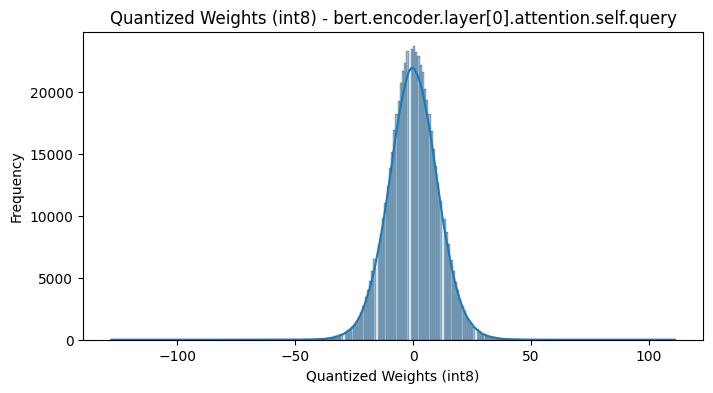

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def weight_distribution(model, layer_name):
    weight = model.bert.encoder.layer[0].attention.self.query.weight()

    scale = weight.q_scale()
    zero_point = weight.q_zero_point()

    int_repr = weight.int_repr()

    min_val = int_repr.min().item()
    max_val = int_repr.max().item()

    print(f"{layer_name}:")
    print(f"Scale: {scale:.6f}, Zero Point: {zero_point}")
    print(f"Min: {min_val}, Max: {max_val}")

    plt.figure(figsize=(8, 4))
    sns.histplot(int_repr.flatten().numpy(), bins=256, kde=True)
    plt.title(f'Quantized Weights (int8) - {layer_name}')
    plt.xlabel('Quantized Weights (int8)')
    plt.ylabel('Frequency')
    plt.show()

weight_distribution(model_ptq_dynamic, "bert.encoder.layer[0].attention.query")

#### 4.2 Evaluation

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
pipe = pipeline("text-classification", model=model_dynamic_quantized, tokenizer=tokenizer)

optim_type = "Dynamic Quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

/usr/local/python/3.10.13/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### 6. Results

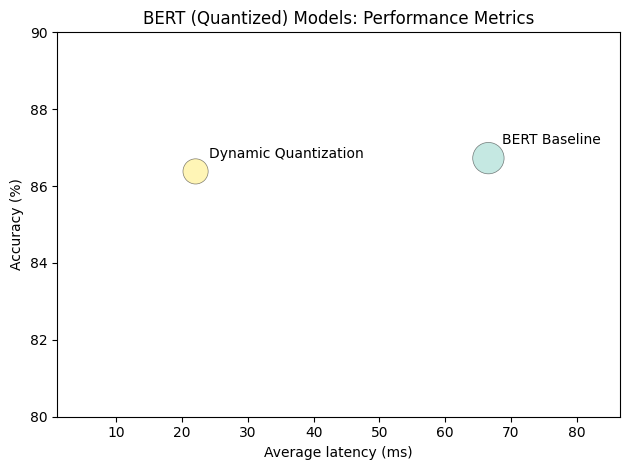

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_metrics(perf_metrics, y_min=80, y_max=90, x_padding=20):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')
    
    fig, ax = plt.subplots()
    sizes = np.sqrt(df["size_mb"]) * 25  # Scale sizes for better visibility
    
    scatter = ax.scatter(df["time_avg_ms"], df["accuracy"] * 100,
                         s=sizes, alpha=0.5, c=range(len(df)), cmap='Set3', edgecolors='black', linewidth=0.5)
    
    # Add labels
    for idx, row in df.iterrows():
        ax.annotate(idx, (row["time_avg_ms"], row["accuracy"] * 100),
                    xytext=(10, 10), textcoords='offset points') 
    
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(1, df["time_avg_ms"].max() + x_padding)
    ax.set_ylabel("Accuracy (%)")
    ax.set_xlabel("Average latency (ms)")
    ax.set_title("BERT (Quantized) Models: Performance Metrics")
    
    plt.tight_layout()
    plt.show()

plot_metrics(perf_metrics)

In [ ]:
perf_metrics

{'BERT Baseline': {'size_mb': 418.14690494537354,
  'time_avg_ms': np.float64(66.56128514999921),
  'time_std_ms': np.float64(7.1043671034855205),
  'accuracy': 0.8672727272727273},
 'Dynamic Quantization': {'size_mb': 173.18227100372314,
  'time_avg_ms': np.float64(22.055510930003948),
  'time_std_ms': np.float64(5.500500611905444),
  'accuracy': 0.8638181818181818}}